## とりあえず鈴木さんのコードを参考にして、時間刻みと2~3日刻みの状態遷移図出してみる

In [28]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pylab as plt
import os
os.environ["DJANGO_SETTINGS_MODULE"] = "analyzer.settings"
import sys
import django
django.setup()
import datetime
from datetime import timedelta
import pickle
import scipy
from scipy import cluster
import pandas
import seaborn

In [20]:
#2015年の参加者の歩行記録が入ったpickleから読み込み
#[チーム名、チーム人数、開始日、ID、合計歩数、合計距離、完歩判定、1日ごとの歩数]
with open('kampo_list.pickle', mode='rb') as f:
    keme = pickle.load(f)
#print keme[:10]

In [21]:
#未完の人と完歩の人を分ける
mikan_data = keme[np.where( keme[:, 6] == False ), 7:17].copy()
kampo_data = keme[np.where( keme[:, 6] == True ), 7:17].copy()
mikan_data = mikan_data[0, ]
kampo_data = kampo_data[0, ]

#月ごとのデータを分ける
sep_data = keme[np.where( keme[:, 2] == datetime.date(2015, 9, 11) ), 7:17].copy()
sep_data = sep_data[0, ]

oct_data = keme[np.where( keme[:, 2] == datetime.date(2015, 10, 6) ), 7:17].copy()
oct_data = oct_data[0, ]

nov_data = keme[np.where( keme[:, 2] == datetime.date(2015, 11, 1) ), 7:17].copy()
nov_data = nov_data[0, ]

In [22]:
# それぞれ ゼロばっかりの記録の人を除く
print sep_data.shape, oct_data.shape, nov_data.shape

rows = np.array([])
for i in range(len(sep_data)):
    if sum(sep_data[i]) == 0.0:
        rows = np.append( rows, i )
sep_data = np.delete( sep_data, rows, 0 )

rows = np.array([])
for i in range(len(oct_data)):
    if sum(oct_data[i]) == 0.0:
        rows = np.append( rows, i )
oct_data = np.delete( oct_data, rows, 0 )

rows = np.array([])
for i in range(len(nov_data)):
    if sum(nov_data[i]) == 0.0:
        rows = np.append( rows, i )
nov_data = np.delete( nov_data, rows, 0 )

print sep_data.shape, oct_data.shape, nov_data.shape

(189, 10) (388, 10) (460, 10)
(127, 10) (259, 10) (318, 10)


In [32]:
X = np.vstack([ sep_data, oct_data, nov_data ])

In [23]:
#杉山先生の量子化結果
#codebookに各クラスタの代表歩数を入れとく
codebook = np.array([ 18064.2734375, 6483.97900391, 8558.92480469, 2849.14038086, 
                     11663.4296875, 832.01855469, 33613.1328125, 4715.02880859])
codebook = np.sort(codebook)
print codebook

[   832.01855469   2849.14038086   4715.02880859   6483.97900391
   8558.92480469  11663.4296875   18064.2734375   33613.1328125 ]


In [24]:
# codebookを参照して月ごとのデータを離散化
# 各データをセントロイドに分類する
# ----------9月のデータ-------------#
data = sep_data.copy()
data = data.astype(np.float32)
data.shape = 1270,

sep_code, dist = scipy.cluster.vq.vq(data, codebook)

# print "portion of each code: "
# for i in xrange(8):
#     print "num of [%d]: " % i, np.count_nonzero((sep_code == i))
sep_code.shape = (127, 10)


# ----------10月のデータ-------------#
data = oct_data.copy()
data = data.astype(np.float32)
data.shape = 2590,

oct_code, dist = scipy.cluster.vq.vq(data, codebook)

# print "portion of each code: "
# for i in xrange(8):
#     print "num of [%d]: " % i, np.count_nonzero((oct_code == i))
oct_code.shape = (259, 10)


# ----------11月のデータ-------------#
data = nov_data.copy()
data = data.astype(np.float32)
data.shape = 3180,

nov_code, dist = scipy.cluster.vq.vq(data, codebook)

# print "portion of each code: "
# for i in xrange(8):
#     print "num of [%d]: " % i, np.count_nonzero((nov_code == i))
nov_code.shape = (318, 10)

In [26]:
sep_data = sep_code.copy()
oct_data = oct_code.copy()
nov_data = nov_code.copy()

## 状態遷移図を描く

In [30]:
import networkx as nx
import numpy
import scipy.cluster
from sklearn.preprocessing import normalize
from nxpd import draw, nxpdParams

def combochart_p(cprobs, data, step_codebook, pthresh=.8, max_width=4., direction='LR'):
    _G = nx.DiGraph()
    _G.graph['rankdir'] = direction
    _G.graph['dpi'] = 600
    _quantities = normalize(
            [numpy.count_nonzero((data == i)) for i in range(len(step_codebook))]
    )[0] * max_width
    for i in numpy.arange(cprobs.shape[0]):
        _node_label = '%d: %d' % (i, step_codebook[i])
        print 'quantity:', _quantities[i]
        _G.add_node(i, label=_node_label, shape='circle', width=_quantities[i])
        for i in xrange(cprobs.shape[0]):
            _sxprobs = cprobs[i] ## probabilities of s_x, s in S(step class)
            _sorted_sxprobs = sorted(_sxprobs, reverse=True)
            _sum_p = 0
            _applied_sxprobs_idxs = []
            for p in _sorted_sxprobs:
                _sum_p += p
                if _sum_p > pthresh: break
                _idx, = numpy.where(_sxprobs == p)
                _applied_sxprobs_idxs.append(_idx[0])
            for j, idx in enumerate(_applied_sxprobs_idxs):
                _label = ' %.2f' % cprobs[i][idx] if cprobs[i][idx] > .01 else ' %.2e' % cprobs[i][j]
                _G.add_edge(
                    i, idx,
                    penwidth=max_width - i if max_width - i > 0 else 1,
                    label=_label,
                    color='black' if i == idx else 'blue' if i < idx else 'red',
                    weight=i,
                    fontsize=18
                )
    return _G

In [36]:
N = 8
# 雨->晴の場合に切り出し
hoge = np.vstack( [sep_data[:, 6:8],
                  nov_data[:, 1:3],
                  nov_data[:, 8:10]] )
print hoge.shape
# s0->s0に遷移する確率みたいな感じを順番に数える
percent = np.array([[0.0 for i in range(N)] for j in range(N)])
for i in range(N):
    for j in range(N):
        percent[i, j] = float(np.count_nonzero( (hoge[:, 0] == i) & (hoge[:, 1] == j) )) / float(np.count_nonzero( (hoge[:, 0] == i)))
print np.around(percent, 4)

(763, 2)
[[ 0.3231  0.1615  0.1308  0.1308  0.1154  0.0846  0.0385  0.0154]
 [ 0.0845  0.2042  0.162   0.1972  0.1479  0.1479  0.0282  0.0282]
 [ 0.0576  0.1655  0.1655  0.1942  0.1511  0.1871  0.0647  0.0144]
 [ 0.0496  0.1405  0.1405  0.2231  0.2066  0.157   0.0661  0.0165]
 [ 0.0215  0.0968  0.1398  0.172   0.2688  0.172   0.1183  0.0108]
 [ 0.0526  0.0211  0.0947  0.1263  0.1368  0.3053  0.2211  0.0421]
 [ 0.      0.0556  0.0278  0.0278  0.1389  0.2222  0.4444  0.0833]
 [ 0.      0.      0.      0.      0.      0.1429  0.4286  0.4286]]


/var/lib/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



quantity: 1.29812070094
quantity: 1.41845633949
quantity: 1.55834651932
quantity: 1.75539612745
quantity: 1.7012450901
quantity: 1.73433739071
quantity: 0.922071830445
quantity: 0.201562194584


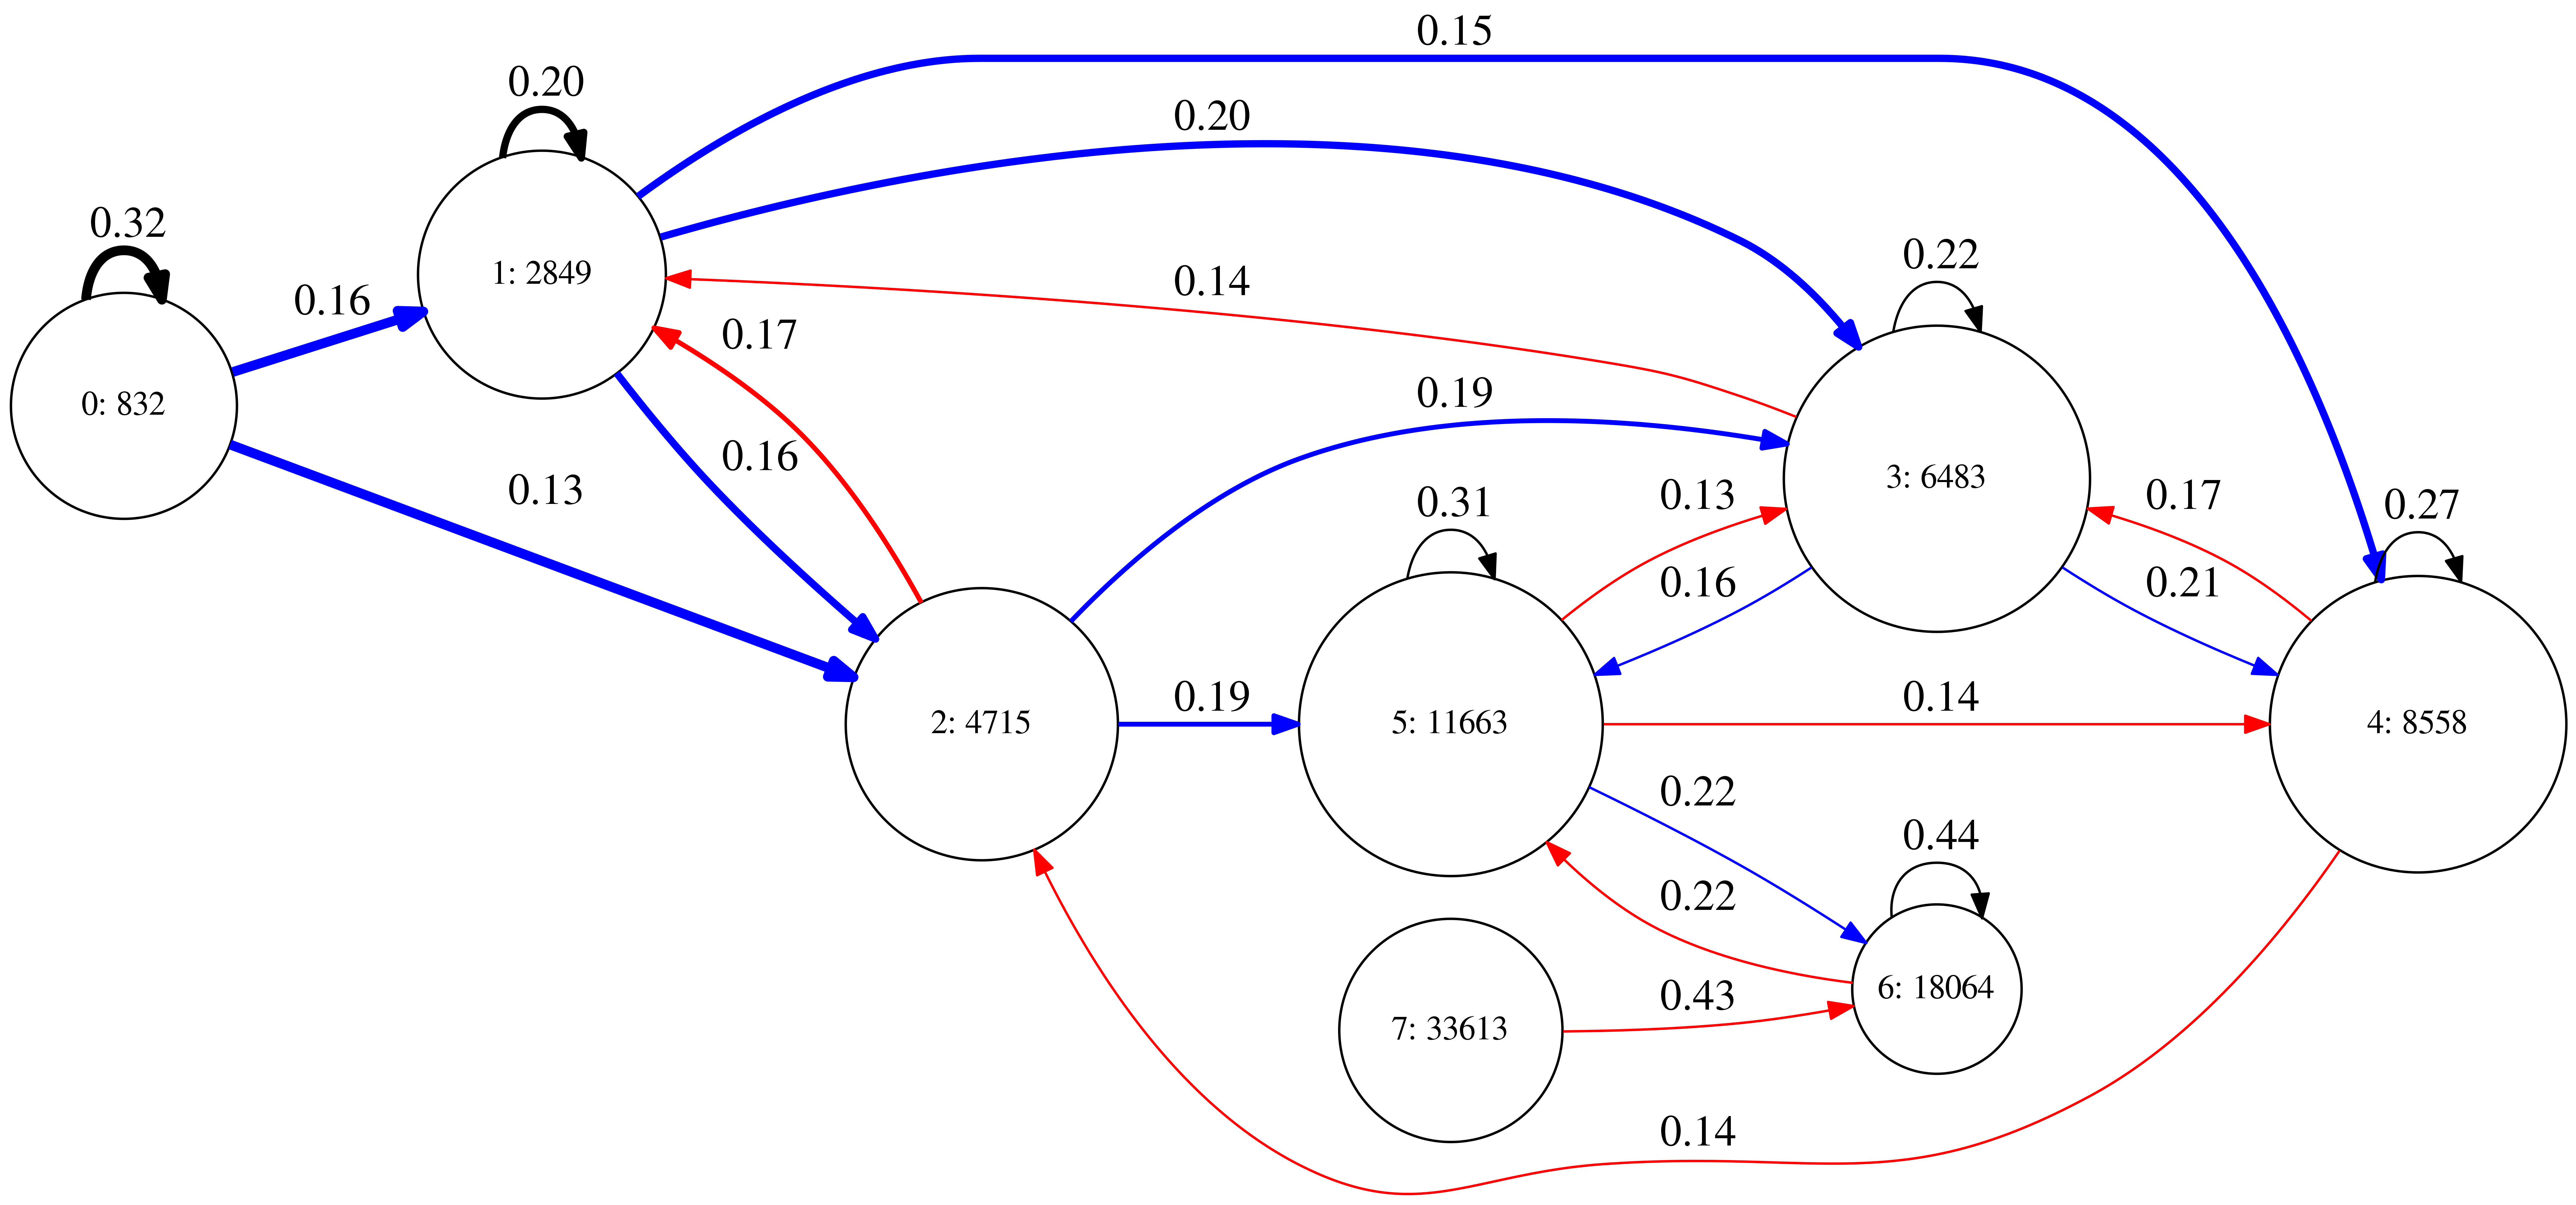

In [33]:
counts_df = pandas.DataFrame(percent)
# plt.figure(figsize=(11, 8))
# seaborn.heatmap(counts_df, annot=False, fmt='g', cmap='Greens')
# plt.show()

# nxpdParams['show'] = 'ipynb'
# draw(combochart(counts_df, codebook, None, nrank=2, thresh=.15))
P = percent
sorted_codebook = codebook
nxpdParams['show'] = 'ipynb'
# draw(combochart(P, sorted_codebook, None, nrank=2, thresh=.15))
draw(combochart_p(P, X, sorted_codebook, pthresh=.8, direction='LR'))

### とりあえず鈴木さんの状態遷移図描画は理解できたから、次は3日跨ぎの段階的な状態遷移図を作ってみる